# DSML Final Project
Emma Lenze & Kai Rothe

In [13]:
import torch
import torch.nn as nn
from torch.optim import RMSprop
from torch.nn.init import uniform_
from torch.distributions.uniform import Uniform
from random import randint
from tqdm import trange
# import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import os
import datetime

# https://github.com/rtqichen/torchdiffeq
from torchdiffeq import odeint_adjoint as odeint

## Import & visualize data

In [14]:
# import lorenz63 data
X_train_array = np.load('lorenz63_on0.05_train.npy').astype(np.float32)
X_test_array = np.load('lorenz63_test-2.npy').astype(np.float32)

# define data & more
T_train, N = X_train_array.shape
T_test = X_test_array.shape[0]
X_train = torch.tensor(X_train_array, dtype=torch.float32)
X_test = torch.tensor(X_test_array, dtype=torch.float32)

X_train.shape, X_test.shape

(torch.Size([100000, 3]), torch.Size([100000, 3]))

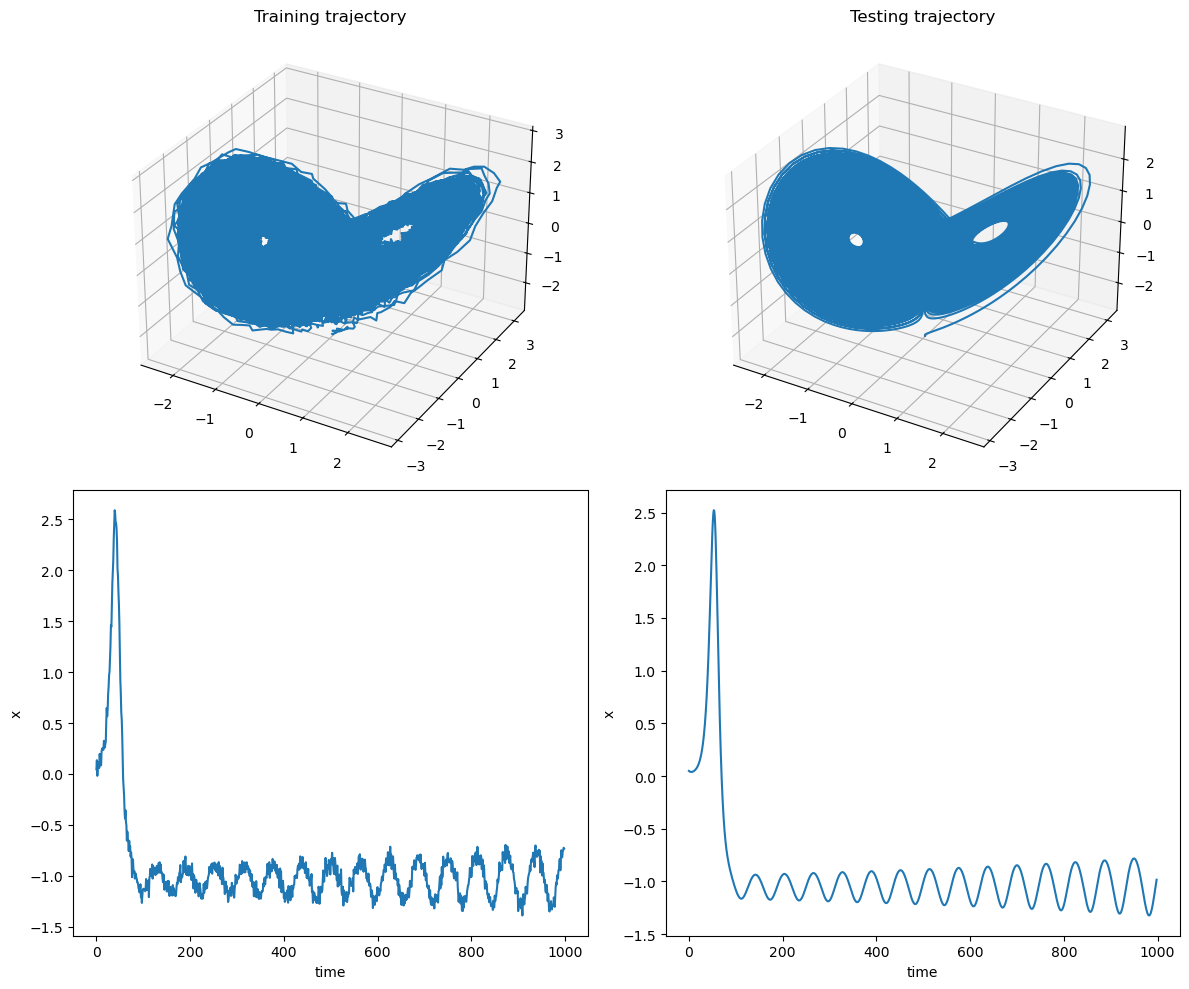

In [15]:
# visualize
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(221, projection='3d')
ax1.plot3D(X_train[:, 0], X_train[:, 1], X_train[:, 2])
ax1.set_title('Training trajectory')

ax2 = fig.add_subplot(222, projection='3d')
ax2.plot3D(X_test[:, 0], X_test[:, 1], X_test[:, 2])
ax2.set_title('Testing trajectory')

ax3 = fig.add_subplot(223)
ax3.plot(X_train[1:1000, 0])
ax3.set_xlabel("time")
ax3.set_ylabel("x")

ax4 = fig.add_subplot(224)
ax4.plot(X_test[1:1000, 0])
ax4.set_xlabel("time")
ax4.set_ylabel("x")

plt.tight_layout()
plt.show()

## The model: NeuralODE

In [16]:
# TODO: make dependent on dimensions etc. like..
# initialize a shallowPLRNN without inputs (K=0), latent dimension M
# equal to the data dimension N=3, and a hidden dimension of L=50
# L is a hyperparameter which controls the expressivity of the model.
# model = shallowPLRNN(M=N, L=hidden_size, K=0)

class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential( #TODO: change architecture
            nn.Linear(3, 50),
            nn.ReLU(),
            nn.Linear(50, 3),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        """generate derivatives from time series starting from y0, evaluated at time points t"""
        return self.net(y)
    
    def generate_trajectory(self, t, y0):
        """generate trajectory starting from y0, evaluated at time points t"""
        return odeint(self, y0, t)

# Training

In [17]:
# training utilities

# hyperparameters
method = 'dopri5' # choices=['dopri5', 'adams']
sequence_length = 70 # 75 # 10
batch_size = 49 # 20
learning_rate = 4.287952173910931e-05
num_epochs = 702 # 5000 # 2000
test_freq = 10
time_step = 1 # 0.01 originally but with 1 muuuch faster.. 

batch_t = torch.arange(0., time_step * sequence_length, step=time_step, dtype = torch.float32)

# TODO: build dataset like in template 11
# initialize the data set using the training data
# sequence_length and batch_size are hyperparameters, where the former has generally
# a larger impact on performance (and also runtime)
# dataset = TimeSeriesDataset(X_train, sequence_length=sequence_length, batch_size=batch_size)
def get_batch(): # dependent on Y_train, sequence_length, T, batch_size, batch_t
    s = torch.from_numpy(np.random.choice(np.arange(T_train - sequence_length, dtype=np.int64), batch_size, replace=False))
    batch_y0 = X_train[s]  # batch_size x N
    batch_y = torch.stack([X_train[s + i] for i in range(sequence_length)], dim=0) # sequence_length x batch_size x N
    return batch_y0, batch_t, batch_y


def train(model): # dependent on model, dataset = Y_train, optimizer, loss_fn, num_epochs
    """
    Simple training method. Train `model` for `num_epochs` where one epoch is defined
    by processing a single training batch.
    """
    func = model
    optimizer = RMSprop(func.parameters(), lr=1e-3) # TODO: maybe rather use torch.optim.RAdam(model.parameters(), lr=learning_rate)
    losses = []
    
    with trange(num_epochs, unit="batches") as pbar:
        pbar.set_description(f"Training Progress")
        
        for epoch in pbar:
            optimizer.zero_grad()
            batch_y0, batch_t, batch_y = get_batch()
            pred_y = odeint(func, batch_y0, batch_t)
            loss = torch.mean(torch.abs(pred_y - batch_y)) # TODO maybe rather use: loss_fn = nn.MSELoss(); loss = loss_fn(pred_y, batch_y)
            loss.backward()
            optimizer.step()
            
            if epoch % test_freq == 0:
                pbar.set_postfix(loss=loss.item())
            losses.append(loss.item())
    
    return losses

In [ ]:
# actual training routine call
model = ODEFunc()
losses = train(model)

# you can save the model here
# current_time = datetime.datetime.now()
# model_name = "NeuralODEFunc" + "_" + str(current_time)
# torch.save(model.state_dict(), "./models/" + model_name + ".pt")

Training Progress:  26%|██▌       | 184/702 [17:05:17<81:20:04, 565.26s/batches, loss=0.685]  

In [ ]:
# plot the loss
plt.plot(losses)
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title("Training loss")
# plt.yscale("log")
plt.show()

## Evaluation

In [ ]:
# draw random trajectory within phase space of training trajectory
max_values = torch.max(X_train, dim = 0)[0]
min_values = torch.min(X_train, dim = 0)[0]
unif_distr = Uniform(min_values, max_values)
y0 = unif_distr.rsample((1,))[0]

test_precision = 1
t_gen = torch.arange(0., T_train * time_step, test_precision, dtype = torch.float32)
traj_generated = model.generate_trajectory(t_gen, y0)

In [ ]:
# plot true and generated trajectory
x, y, z = torch.asarray(X_test).T
x_sim, y_sim, z_sim = torch.asarray(traj_generated).T
x0, y0, z0 = x_sim[0], y_sim[0], z_sim[0]
# x_final, y_final, z_final = x_sim[], y_sim[], z_sim[]

fig = plt.figure(figsize = (10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')

# to asses time_scale: use..
# end = torch.unique(traj_generated, dim = 0).shape[0]
# print(end)
ax1.plot(x,y,z) # ax1.plot(x[:end],y[:end],z[:end])
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
ax1.set_title("ground truth")
# ax1.scatter(x0, y0, z0, c='g', label = "start")
# ax1.scatter(x_final, y_final, z_final, c='r', label = "end")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_sim,y_sim,z_sim)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")
ax2.set_title("simulated trajectory")
ax2.scatter(x0, y0, z0, c='g', label = "start")
# ax2.scatter(x_final, y_final, z_final, c='r', label = "end")

plt.show()

In [ ]:
# include psd.py snippet

SMOOTHING_SIGMA = 20

#compute power spectra distances and average across all dimensions
def power_spectrum_error(x_gen, x_true):
    pse_errors_per_dim = power_spectrum_error_per_dim(x_gen, x_true)
    return np.array(pse_errors_per_dim).mean(axis=0)

def compute_power_spectrum(x):
    fft_real = np.fft.rfft(x)
    ps = np.abs(fft_real)**2
    ps_smoothed = gaussian_filter1d(ps, SMOOTHING_SIGMA)
    return ps_smoothed

def get_average_spectrum(x):
    x_ = (x - x.mean()) / x.std()  # normalize individual trajectories
    spectrum = compute_power_spectrum(x_)
    return spectrum / spectrum.sum()

def power_spectrum_error_per_dim(x_gen, x_true): # Batch Size x Time x Dimension 
    assert x_true.shape[1] == x_gen.shape[1]
    assert x_true.shape[2] == x_gen.shape[2]
    dim_x = x_gen.shape[2]
    pse_per_dim = []
    for dim in range(dim_x):
        spectrum_true = get_average_spectrum(x_true[:, :, dim])
        spectrum_gen = get_average_spectrum(x_gen[:, :, dim])
        hd = hellinger_distance(spectrum_true, spectrum_gen)
        pse_per_dim.append(hd)
    return pse_per_dim

def hellinger_distance(p, q):
    return 1 / np.sqrt(2) * np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q))**2))

#functions for smoothing power spectra with a Gaussian kernel
def kernel_smoothen(data, kernel_sigma=1):
    """
    Smoothen data with Gaussian kernel
    @param kernel_sigma: standard deviation of gaussian, kernel_size is adapted to that
    @return: internal data is modified but nothing returned
    """
    kernel = get_kernel(kernel_sigma)
    data_final = data.copy()
    data_conv = np.convolve(data[:], kernel)
    pad = int(len(kernel) / 2)
    data_final[:] = data_conv[pad:-pad]
    data = data_final
    return data

def gauss(x, sigma=1):
    return 1 / np.sqrt(2 * np.pi * sigma ** 2) * np.exp(-1 / 2 * (x / sigma) ** 2)

def get_kernel(sigma):
    size = sigma * 10 + 1
    kernel = list(range(size))
    kernel = [float(k) - int(size / 2) for k in kernel]
    kernel = [gauss(k, sigma) for k in kernel]
    kernel = [k / np.sum(kernel) for k in kernel]
    return kernel

In [ ]:
# compute power spectrum
num_batches = 1 # T_test // sequence_length
power_spectrum_error(traj_generated.detach().numpy().reshape(num_batches, T_test // num_batches, 3), X_test.detach().numpy().reshape(num_batches, T_test // num_batches, 3))

In [12]:
#hyperparameter optimization
import optuna

def objective(trial):
    # Definition der Hyperparameter, die optimiert werden sollen
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_int('batch_size', 8, 75, log=True)
    num_epochs = trial.suggest_int('num_epochs', 10, 1000)
    sequence_length = trial.suggest_int('sequence_length', 10, 100)

    # Trainieren des Modells
    losses = train(model)

    return losses[-1]

if __name__ == '__main__':
    # Erstellen und Ausführen der Optuna-Studie
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=10)

    # Ausgabe der besten Hyperparameter-Kombination
    print("Beste Hyperparameter-Kombination gefunden:")
    print(study.best_params)
    print("Minimaler Verlust:", study.best_value)

[I 2024-03-01 09:28:06,266] A new study created in memory with name: no-name-125de541-a08b-4567-9855-c73aec2496b7
Training Progress: 100%|██████████| 100/100 [15:58<00:00,  9.58s/batches, loss=0.0685]
[I 2024-03-01 09:44:04,669] Trial 0 finished with value: 0.0674138218164444 and parameters: {'learning_rate': 2.411413210333492e-05, 'batch_size': 53, 'num_epochs': 962, 'sequence_length': 46}. Best is trial 0 with value: 0.0674138218164444.
Training Progress: 100%|██████████| 100/100 [15:48<00:00,  9.49s/batches, loss=0.0583]
[I 2024-03-01 09:59:53,415] Trial 1 finished with value: 0.059200648218393326 and parameters: {'learning_rate': 0.003447459093699564, 'batch_size': 48, 'num_epochs': 310, 'sequence_length': 36}. Best is trial 1 with value: 0.059200648218393326.
Training Progress: 100%|██████████| 100/100 [14:41<00:00,  8.82s/batches, loss=0.0601]
[I 2024-03-01 10:14:35,377] Trial 2 finished with value: 0.05810073763132095 and parameters: {'learning_rate': 0.0016838503455811947, 'bat

Beste Hyperparameter-Kombination gefunden:
{'learning_rate': 4.287952173910931e-05, 'batch_size': 49, 'num_epochs': 702, 'sequence_length': 70}
Minimaler Verlust: 0.05028252676129341
